https://pennylane.ai/qml/demos/tutorial_expressivity_fourier_series.html#part-i-fitting-fourier-series-with-serial-pauli-rotation-encoding

In [2]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np

np.random.seed(42)

In [3]:
def square_loss(targets, predictions):
	loss = 0
	for t, p in zip(targets, predictions):
		loss += (t - p) ** 2
	loss = loss / len(targets)
	return 0.5*loss

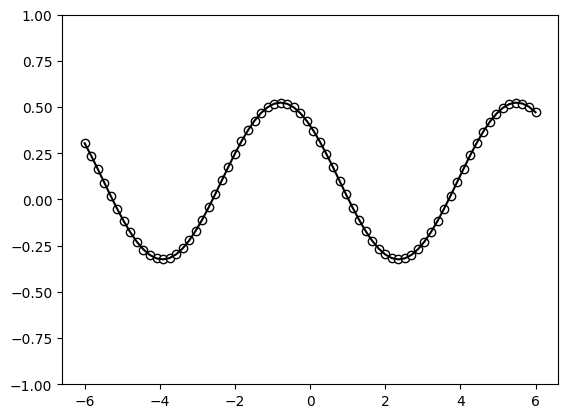

In [4]:
degree = 1  # degree of the target function
scaling = 1  # scaling of the data
coeffs = [0.15 + 0.15j]*degree  # coefficients of non-zero frequencies
coeff0 = 0.1  # coefficient of zero frequency

def target_function(x):
    """Generate a truncated Fourier series, where the data gets re-scaled."""
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128(scaling * (idx+1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

x = np.linspace(-6, 6, 70, requires_grad=False)
target_y = np.array([target_function(x_) for x_ in x], requires_grad=False)

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.show();

In [8]:
scaling = 1

dev = qml.device('default.qubit', wires=1) 

def S(x):
    """Data-encoding circuit block."""
    qml.RX(scaling * x, wires=0)#(rotation angle, wires)

def W(theta):
    """Trainable circuit block."""
    qml.Rot(theta[0], theta[1], theta[2], wires=0)#Three rotation angles, on the 1st qubit


@qml.qnode(dev)
def serial_quantum_model(weights, x):
	#for each weight, encode and themn 
    for theta in weights[:-1]:
        W(theta)
        S(x)

    # (L+1)'th unitary
    W(weights[-1])

    return qml.expval(qml.PauliZ(wires=0))
weights = 2 * np.pi * np.random.random(size=(r+1, 3), requires_grad=True) # some random initial weights
print(qml.draw(serial_quantum_model)(weights, x[-1]))

0: ──Rot(0.36,5.44,3.78)──RX(6.00)──Rot(4.45,0.13,6.09)─┤  <Z>


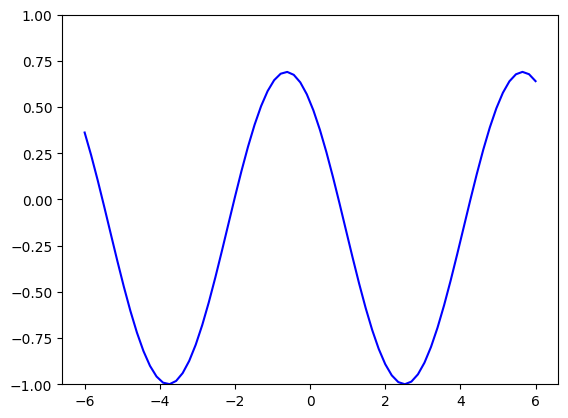

In [9]:
r = 1 # number of times the encoding gets repeated (here equal to the number of layers)
weights = 2 * np.pi * np.random.random(size=(r+1, 3), requires_grad=True) # some random initial weights

x = np.linspace(-6, 6, 70, requires_grad=False)
random_quantum_model_y = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

Cost at step  10: 0.012945854197262298
Cost at step  20: 0.01804236977169547
Cost at step  30: 0.00927937985749934
Cost at step  40: 0.0004954720296709104
Cost at step  50: 0.0019716679101815385


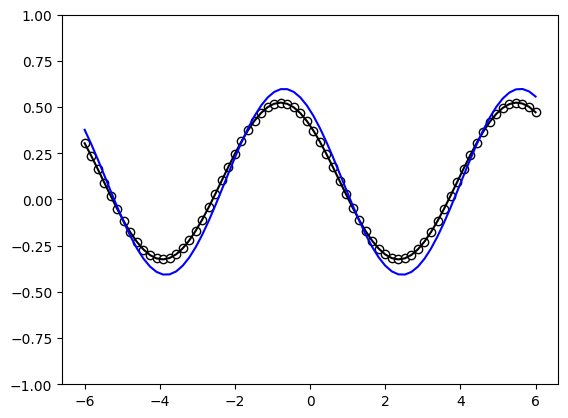

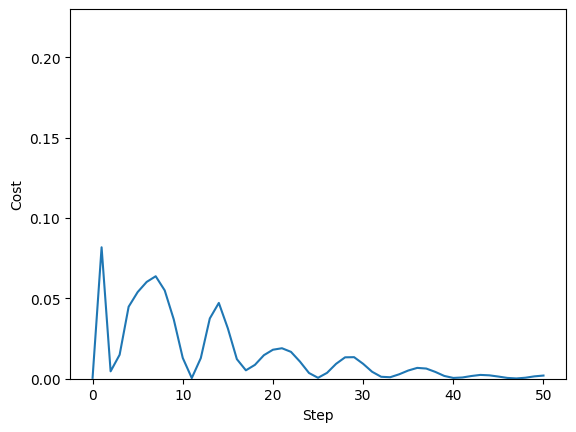

In [12]:
def cost(weights, x, y):
    predictions = [serial_quantum_model(weights, x_) for x_ in x]
    return square_loss(y, predictions)

max_steps = 50
opt = qml.AdamOptimizer(0.3) #PennyLane's own AdamOptimizer
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # Update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

predictions = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show();

plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.ylim(0, 0.23)
plt.show();

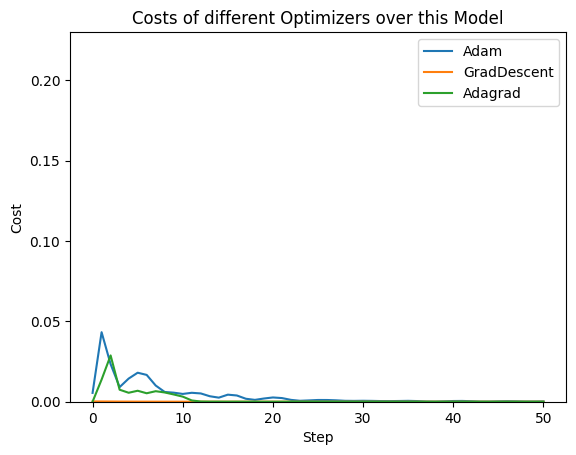

In [28]:
max_steps = 50
batch_size = 25
optimizer_names = ["Adam", "GradDescent", "Adagrad"]
for idx, opt in enumerate([qml.AdamOptimizer(0.3), qml.GradientDescentOptimizer(0.3), qml.AdagradOptimizer(0.3)]):
	cst=[cost(weights, x, target_y)] #initial cost
	for step in range(max_steps):
		batch_index = np.random.randint(0, len(x), (batch_size,)) # Select batch of data
		x_batch = x[batch_index]
		y_batch = target_y[batch_index]

		# Update the weights by one optimizer step
		weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

		c = cost(weights, x, target_y)
		cst.append(c)

	predictions = [serial_quantum_model(weights, x_) for x_ in x]
	plt.plot(range(len(cst)), cst, label=optimizer_names[idx])
	plt.ylabel("Cost")
	plt.xlabel("Step")
	plt.ylim(0, 0.23)
plt.title("Costs of different Optimizers over this Model")
plt.legend()
plt.show()

# In Parallel

In [41]:
from pennylane.templates import StronglyEntanglingLayers

In [42]:
n_ansatz_layers = 2
n_qubits = 3

dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def ansatz(weights):
    StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.Identity(wires=0))

weights_ansatz = 2 * np.pi * np.random.random(size=(n_ansatz_layers, n_qubits, 3))
print(qml.draw(ansatz, expansion_strategy="device")(weights_ansatz))

0: ──Rot(5.33,3.90,1.13)─╭●────╭X──Rot(0.65,1.01,3.15)─╭●─╭X────┤  <I>
1: ──Rot(1.33,0.04,4.47)─╰X─╭●─│───Rot(5.81,1.55,5.19)─│──╰●─╭X─┤     
2: ──Rot(3.05,5.97,4.49)────╰X─╰●──Rot(1.96,1.70,5.66)─╰X────╰●─┤     


In [43]:
scaling = 1
r = 3

dev = qml.device('default.qubit', wires=r)

def S(x):
    """Data-encoding circuit block."""
    for w in range(r):
        qml.RX(scaling * x, wires=w)

def W(theta):
    """Trainable circuit block."""
    StronglyEntanglingLayers(theta, wires=range(r))


@qml.qnode(dev)
def parallel_quantum_model(weights, x):

    W(weights[0])
    S(x)
    W(weights[1])

    return qml.expval(qml.PauliZ(wires=0))

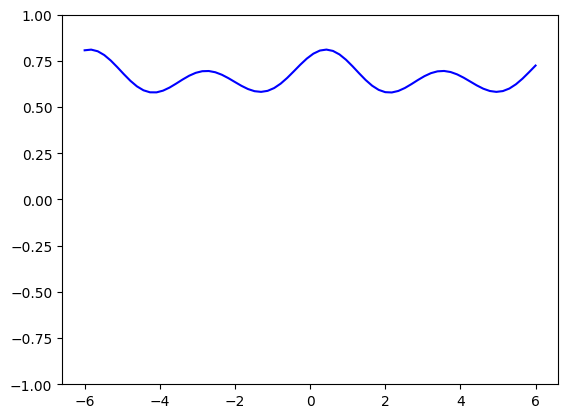

In [44]:
trainable_block_layers = 3
weights = 2 * np.pi * np.random.random(size=(2, trainable_block_layers, r, 3), requires_grad=True)

x = np.linspace(-6, 6, 70, requires_grad=False)
random_quantum_model_y = [parallel_quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show();

Cost at step  10: 0.025020530928328774
Cost at step  20: 0.005108681642275939
Cost at step  30: 0.012096421493755448
Cost at step  40: 0.0017009023948024705
Cost at step  50: 0.0006025286541379806


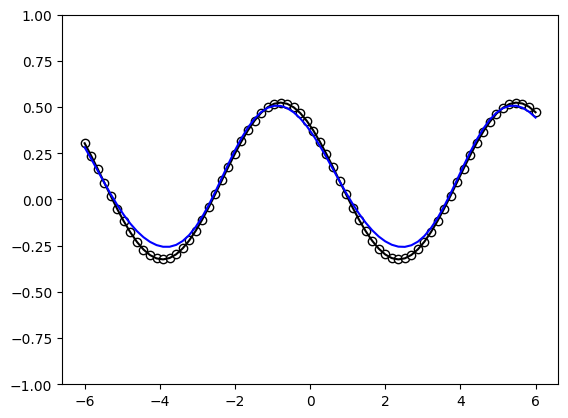

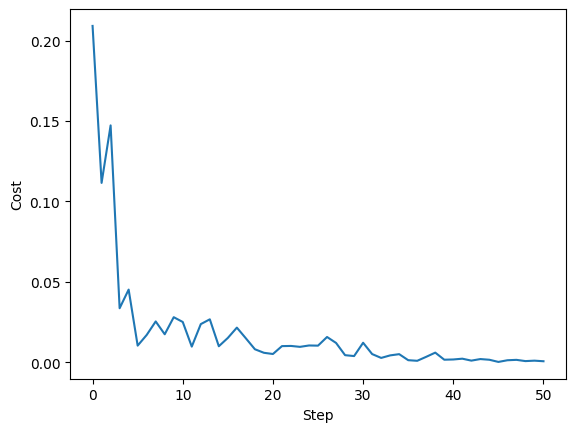

In [45]:
def cost(weights, x, y):
    predictions = [parallel_quantum_model(weights, x_) for x_ in x]
    return square_loss(y, predictions)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

predictions = [parallel_quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show();

plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.show();

# Fourier Coefficients

In [36]:
def fourier_coefficients(f, K):
    """
    Computes the first 2*K+1 Fourier coefficients of a 2*pi periodic function.
    """
    n_coeffs = 2 * K + 1
    t = np.linspace(0, 2 * np.pi, n_coeffs, endpoint=False)
    y = np.fft.rfft(f(t)) / t.size
    return y


In [37]:
from pennylane.templates import BasicEntanglerLayers

scaling = 1
n_qubits = 4

dev = qml.device('default.qubit', wires=n_qubits)

def S(x):
    """Data encoding circuit block."""
    for w in range(n_qubits):
        qml.RX(scaling * x, wires=w)

def W(theta):
    """Trainable circuit block."""
    BasicEntanglerLayers(theta, wires=range(n_qubits))


@qml.qnode(dev)
def quantum_model(weights, x):

    W(weights[0])
    S(x)
    W(weights[1])

    return qml.expval(qml.PauliZ(wires=0))

n_ansatz_layers = 1

def random_weights():
    return 2 * np.pi * np.random.random(size=(2, n_ansatz_layers, n_qubits))

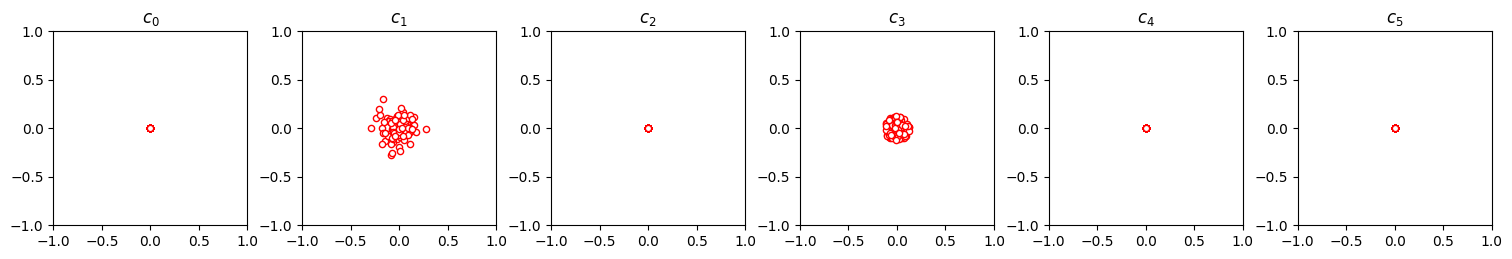

In [38]:
n_coeffs = 5
n_samples = 100


coeffs = []
for i in range(n_samples):

    weights = random_weights()

    def f(x):
        return np.array([quantum_model(weights, x_) for x_ in x])

    coeffs_sample = fourier_coefficients(f, n_coeffs)
    coeffs.append(coeffs_sample)

coeffs = np.array(coeffs)
coeffs_real = np.real(coeffs)
coeffs_imag = np.imag(coeffs)

n_coeffs = len(coeffs_real[0])

fig, ax = plt.subplots(1, n_coeffs, figsize=(15, 4))

for idx, ax_ in enumerate(ax):
    ax_.set_title(r"$c_{}$".format(idx))
    ax_.scatter(coeffs_real[:, idx], coeffs_imag[:, idx], s=20,
                facecolor='white', edgecolor='red')
    ax_.set_aspect("equal")
    ax_.set_ylim(-1, 1)
    ax_.set_xlim(-1, 1)


plt.tight_layout(pad=0.5)
plt.show();

# ContinuousVariable Model

In [39]:
var = 2
n_ansatz_layers = 1
dev_cv = qml.device('default.gaussian', wires=1)

def S(x):
    qml.Rotation(x, wires=0)

def W(theta):
    """Trainable circuit block."""
    for r_ in range(n_ansatz_layers):
        qml.Displacement(theta[0], theta[1], wires=0)
        qml.Squeezing(theta[2], theta[3], wires=0)

@qml.qnode(dev_cv)
def quantum_model(weights, x):
    W(weights[0])
    S(x)
    W(weights[1])
    return qml.expval(qml.X(wires=0))

def random_weights():
    return np.random.normal(size=(2, 5 * n_ansatz_layers), loc=0, scale=var)